 Copyright © Sorbonne University.

 This source code is licensed under the MIT license found in the
 LICENSE file in the root directory of this source tree.

 这段源代码的许可协议是 MIT 许可协议，详细信息请参见根目录中的 LICENSE 文件。

# Outlook

In this notebook we will study basic reinforcement learning
algorithms: TD learning, Q-learning and SARSA. We will also investigate two
basic exploration strategies: $\epsilon$-greedy and softmax.

在本笔记中，我们将学习基本的强化学习算法：TD学习、Q学习和SARSA。我们还将研究两种基本的探索策略：$\epsilon$-贪婪策略 和 softmax 策略。


## Initialization

We begin by loading all the modules necessary for this notebook.

我们首先加载本笔记所需的所有模块。

In [1]:
try:
    from easypip import easyimport
except ModuleNotFoundError:
    from subprocess import run
    assert run(["pip", "install", "easypip"]).returncode == 0, "Could not install easypip"
    from easypip import easyimport

easyimport("swig")
easyimport("bbrl_utils").setup(maze_mdp=True)

import os
from pathlib import Path
from typing import List, Tuple

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
from bbrl_gymnasium.envs.maze_mdp import MazeMDPEnv
from bbrl_utils.notebook import tqdm
from mazemdp.mdp import Mdp
from mazemdp.toolbox import egreedy, egreedy_loc, sample_categorical, softmax
from mazemdp import random_policy
import bbrl_gymnasium  # noqa: F401

# Settings
NB_EPISODES = 100
TIMEOUT = 25

Matplotlib backend: module://matplotlib_inline.backend_inline


/home/chen_guanyu/deepdac/lib/python3.10/site-packages/bbrl_utils/notebook.py:46: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm  # noqa: F401
error: XDG_RUNTIME_DIR not set in the environment.


# Reinforcement Learning

Reinforcement Learning is about finding the optimal policy in an MDP which is
initially unknown to the agent. More precisely, the state and action spaces
are known, but the agent does not know the transition and reward functions.
Generally speaking, the agent has to explore the MDP to figure out which
action in which state leads to which other state and reward. The model-free
case is about finding this optimal policy just through very local updates,
without storing any information about previous interactions with the
environment. Principles of these local updates can already be found in the
Temporal Difference (TD) algorithm, which iteratively computes optimal values
for all state using local updates. The most widely used model-free RL
algorithms are **q-learning**, **SARSA** and **actor-critic** algorithms.

As for dynamic programming, we first create a maze-like MDP. Reinforcement
learning is slower than dynamic programming, so we will work with smaller
mazes.

# 强化学习

强化学习旨在找到智能体在一个初始未知的 MDP 中的最优策略。具体来说，状态和动作空间是已知的，但智能体不知道转移函数和奖励函数。通常情况下，智能体必须探索 MDP，以了解在某个状态下执行某个动作会导致哪个状态以及相应的奖励。无模型的情况是指智能体通过局部更新来找到最优策略，而不存储任何关于与环境之前交互的信息。局部更新的原理可以在时序差分（Temporal Difference，TD）算法中找到，该算法通过迭代局部更新来为所有状态计算最优值。最常用的无模型强化学习算法包括 **Q-learning**、**SARSA** 和 **actor-critic** 算法。

与动态规划类似，我们首先创建一个类似迷宫的 MDP。由于强化学习比动态规划更慢，因此我们将使用较小的迷宫。

In [2]:
import gymnasium as gym

# Environment with 20% of walls and no negative reward when hitting a wall
env = gym.make(
    "MazeMDP-v0",
    kwargs={"width": 4, "height": 3, "ratio": 0.2, "hit": 0.0},
    render_mode="human",
)
env.reset()
env.unwrapped.init_draw("The maze")

       [ 2,  3,  4],
       [ 5,  6,  7],
       [-1,  8,…

# Temporal Difference (TD) learning ##

Given a state and an action spaces as well as a policy, TD(0) computes the
state value of this policy based on the following equations: 

$$\delta_t = r(s_t,a_t) + \gamma V^{(i)}(s_{t+1})-V^{(i)}(s_t)$$
$$V^{(i+1)}(s_t) = V^{(i)}(s_t) + \alpha\delta_t$$

where $\delta$ is the TD error and $\alpha$ is a parameter called "learning
rate".

The code is provided below, so that you can take inspiration later on. The
important part is the computation of $\delta$, and the update of the values of
$V$.

To run TD learning, a policy is needed as input. Such a policy can be
retreived by using the `policy_iteration_q(mdp)` function defined in the
dynamic programming notebook.

If you want to run this notebook independently, you can use instead the
`random_policy` provided in `mazemdp`. This is what we do here by default,
replace it if you want to run TD learning from an optimal policy.

The ```evaluate``` function below is not necessary for the lab, it is left here for its informative value.

# 时序差分（Temporal Difference, TD）学习

给定状态空间和动作空间，以及一个策略，TD(0) 基于以下公式计算该策略的状态值：

$$\delta_t = r(s_t, a_t) + \gamma V^{(i)}(s_{t+1}) - V^{(i)}(s_t)$$

$$V^{(i+1)}(s_t) = V^{(i)}(s_t) + \alpha \delta_t$$

其中，$\delta$ 是 TD 误差，$\alpha$ 是一个称为“学习率”的参数。

下面提供的代码可以作为后续算法的参考。关键部分是 $\delta$ 的计算和 $V$ 值的更新。

要运行 TD 学习，需要一个策略作为输入。这样的策略可以通过动态规划笔记中定义的 `policy_iteration_q(mdp)` 函数来获取。

如果你想独立运行本笔记，可以使用 `mazemdp` 提供的 `random_policy`。默认情况下，我们在此使用该策略，如果你想从最优策略运行 TD 学习，可以将其替换。

下面的 ```evaluate``` 函数在实验中并非必需，但保留在这里以供参考。

In [3]:
def evaluate(mdp, policy):
    x, _ = mdp.reset(uniform=True)
    done = False
    reward = 0

    while not done:
        # Perform a step of the MDP
        u = sample_categorical(policy[x])
        _, r, done, *_ = mdp.step(u)
        reward += r
    return reward

**Question:** In the code of the *temporal_difference(...)* function below,
fill the missing parts

**问题：** 在下面的 *temporal_difference(...)* 函数代码中，填写缺失的部分。

In [4]:
def temporal_difference(
    mdp: MazeMDPEnv,
    policy: np.ndarray,
    nb_episodes: int = 50,
    alpha: float = 0.2,
    timeout: int = 25,
    render: bool = True,
) -> np.ndarray:
    # alpha: learning rate
    # timeout: timeout of an episode (maximum number of timesteps)
    v = np.zeros(mdp.unwrapped.nb_states)  # initial state value v
    mdp.timeout = timeout

    if render:
        mdp.unwrapped.init_draw("Temporal differences")

    for _ in tqdm(range(nb_episodes)):  # for each episode

        # Draw an initial state randomly (if uniform is set to False, the state
        # is drawn according to the P0 distribution)
        x, _ = mdp.reset(uniform=True)
        terminated = False
        truncated = False
        while not (terminated or truncated):
            # Show agent
            if render:
                mdp.unwrapped.draw_v_pi(v, policy)

            # Step forward following the MDP: x=current state, pol[i]=agent's
            # action according to policy pol, r=reward gained after taking
            # action pol[i], terminated=tells whether  the episode ended, and info
            # gives some info about the process
            y, r, terminated, truncated, _ = mdp.step(
                egreedy_loc(policy[x], mdp.action_space.n, epsilon=0.2)
            )
            # To be completed...
            
            # Update the state value of x
            delta = r + mdp.gamma * v[y] - v[x]
            v[x] = v[x] + alpha * delta
            # assert False, 'Not implemented yet'


            # Update agent's position (state)
            x = y

    if render:
        mdp.current_state = 0
        mdp.unwrapped.draw_v_pi(v, policy)
    return v

Once this is done, you can run it.

当填好了之后，可以运行以下代码。

In [5]:
policy = random_policy(env)
v = temporal_difference(env, policy, nb_episodes=10, timeout=TIMEOUT)

       [ 2,  3,  4],
       [ 5,  6,  7],
       [-1,  8,…

  0%|          | 0/10 [00:00<?, ?it/s]

Unless you were lucky, the generated value function is boring: if the policy
does not reach the final state, all values are 0. To avoid this, you can
copy-paste a dynamic programming function on the Q function from the previous
notebook, use it to get an optimal policy, and use this policy for TD
learning. You should get a much more interesting value function.

除非你很幸运，否则生成的价值函数可能会比较单调：如果策略无法到达终点状态，所有状态的值都会是 0。为了避免这种情况，你可以从之前的笔记中复制一个关于 Q 函数的动态规划函数，使用它来获取最优策略，并将其用于 TD 学习。这样你将会得到一个更加有趣的价值函数。

In [6]:
# Put your code to obtain an optimal Q function here

def value_iteration_q(
    mdp: MazeMDPEnv, render: bool = True
) -> Tuple[np.ndarray, List[float]]:
    q = np.zeros(
        (mdp.nb_states, mdp.action_space.n)
    )  # initial action values are set to 0
    q_list = []
    stop = False

    mdp.init_draw("Value iteration Q")

    mdp.draw_v(q)

    while not stop:
        qold = q.copy()

        mdp.draw_v(q)

        for x in range(mdp.nb_states):
            for u in range(mdp.action_space.n):
                if x in mdp.terminal_states:
                    q[x, u] = mdp.r[x, u]
                else:
                    summ = 0
                    for y in range(mdp.nb_states):
                        summ += mdp.P[x, u, y] * np.max(qold[y, :])

                    # Compléter d'après la formule ci-dessus

                    q[x, u] = mdp.r[x, u] + mdp.gamma * summ
                    # assert False, 'Not implemented yet'


        if (np.linalg.norm(q - qold)) <= 0.01:
            stop = True
        q_list.append(np.linalg.norm(q))

    mdp.draw_v(q)

    return q, q_list

# assert False, 'Not implemented yet'


In [7]:
# Put your code to get a policy from a Q function here

def get_policy_from_q(q: np.ndarray) -> np.ndarray:
    # Outputs a policy given the action values

    return np.argmax(q, axis=1)
    
# assert False, 'Not implemented yet'


In [8]:
# Put your code to run the algorithm here

q, q_list = value_iteration_q(mdp=env, render=True)
policy_q = get_policy_from_q(q)

v_q = temporal_difference(env, policy_q, nb_episodes=10, timeout=TIMEOUT)

# assert False, 'Not implemented yet'


       [ 2,  3,  4],
       [ 5,  6,  7],
       [-1,  8,…

  0%|          | 0/10 [00:00<?, ?it/s]

# Q-learning ##

The **q-learning** algorithm accounts for an agent exploring an MDP and
updating at each step a model of the state action-value function stored into a
Q-table. It is updated as follows:

$$
\delta_t = \left( r(s_t,a_t) + \gamma \max_{a \in A}
Q^{(i)}(s_{t+1},a) \right) -Q^{(i)}(s_t,a_t)
$$

$$Q^{(i+1)}(s_t, a_t) = Q^{(i)}(s_t,a_t) + \alpha \delta_t$$

To visualize the policy, we need the `get_policy_from_q(q)` function that we defined in the
dynamic programming notebook. If you have not done so yet, import it below.

# Q-learning

**Q-learning** 算法考虑的是智能体在探索一个 MDP，并在每一步更新存储在 Q 表中的状态-动作值函数模型。其更新公式如下：

$$
\delta_t = \left( r(s_t,a_t) + \gamma \max_{a \in A} Q^{(i)}(s_{t+1},a) \right) - Q^{(i)}(s_t,a_t)
$$

$$
Q^{(i+1)}(s_t, a_t) = Q^{(i)}(s_t,a_t) + \alpha \delta_t
$$

为了可视化策略，我们需要在动态规划笔记中定义的 `get_policy_from_q(q)` 函数。如果你还没有导入它，可以在下面导入。

In [9]:
# Put your code here

# assert False, 'Not implemented yet'


Fill the code of the `q_learning(...)` function below.

请在下面的 `q_learning(...)` 函数代码中填写缺失的部分。

In [10]:
# --------------------------- Q-Learning epsilon-greedy version -------------------------------#
# Given an exploration rate epsilon, the QLearning algorithm computes the state action-value function
# based on an epsilon-greedy policy
# alpha is the learning rate


def q_learning_eps(
    mdp: MazeMDPEnv,
    epsilon: float,
    nb_episodes: int = 20,
    timeout: int = 50,
    alpha: float = 0.5,
    render: bool = True,
    init_q: float = 0.0,
    uniform: bool = True,
) -> Tuple[np.ndarray, List[float]]:
    # Initialize the state-action value function
    # alpha is the learning rate
    q = np.zeros((mdp.nb_states, mdp.action_space.n))
    q_min = np.zeros((mdp.nb_states, mdp.action_space.n))
    q[:, :] = init_q
    q_list = []
    time_list = []

    # Run learning cycle
    mdp.timeout = timeout  # episode length

    if render:
        mdp.init_draw("Q Learning")

    for _ in range(nb_episodes):
        # Draw the first state of episode i using a uniform distribution over all the states
        x, _ = mdp.reset(uniform=uniform)
        cpt = 0

        terminated = False
        truncated = False
        while not (terminated or truncated):
            # Show the agent in the maze
            if render:
                mdp.draw_v_pi(q, q.argmax(axis=1))

            # Draw an action using an epsilon-greedy policy
            u = egreedy(q, x, epsilon)

            # Perform a step of the MDP
            y, r, terminated, truncated, _ = mdp.step(u)

            # To be completed...

            # Update the state-action value function with q-Learning
            delta = (r + mdp.gamma * max(q[y,:])) - q[x,u]
            q[x,u] = q[x,u] + alpha * delta
            # assert False, 'Not implemented yet'


            # Update the agent position
            x = y
            cpt = cpt + 1

        q_list.append(np.linalg.norm(np.maximum(q, q_min)))
        time_list.append(cpt)

    if render:
        mdp.current_state = 0
        mdp.draw_v_pi(q, get_policy_from_q(q))

    return q, q_list, time_list

And run it.

然后运行代码。

In [11]:
epsilon = 0.02
q, q_list, time_list = q_learning_eps(
    env, epsilon, nb_episodes=NB_EPISODES, timeout=TIMEOUT
)

       [ 2,  3,  4],
       [ 5,  6,  7],
       [-1,  8,…

## Harder case: fixed starting point and exploration

We now explore the case where the agent always start at the *beginning of the maze* (`uniform=False`), corresponding to the top-left corner when this is a free cell.

## 更难的情况：固定起点和探索

我们现在探讨一种情况，即智能体总是从*迷宫的起点*开始（`uniform=False`），对应于左上角的自由单元格。

In [12]:
epsilon = 0.02
start_q, start_q_list, time_list = q_learning_eps(
    env, epsilon, nb_episodes=NB_EPISODES, timeout=TIMEOUT, uniform=False
)

       [ 2,  3,  4],
       [ 5,  6,  7],
       [-1,  8,…

You will observe that it is very difficult for the agent to learn to reach the
final state (and the larger the maze, the more difficult). A simple trick to
avoid this is to initialize the value of each $(s,a)$ pair to a small (lower
than the final reward) value. Try it with the example above !

你会发现，对于智能体来说，很难学会到达终点状态（迷宫越大，难度越大）。一个简单的技巧是将每对 $(s,a)$ 的初始值设置为一个较小的值（小于最终奖励）。尝试在上面的例子中应用这个技巧！

In [13]:
# To be completed...

# Put your code to run q_learning_eps here

epsilon = 0.02
start_q, start_q_list, time_list = q_learning_eps(
    env, epsilon, nb_episodes=NB_EPISODES, timeout=TIMEOUT, init_q=5.5, uniform=False
)

# assert False, 'Not implemented yet'


       [ 2,  3,  4],
       [ 5,  6,  7],
       [-1,  8,…

### Learning dynamics

By watching carefully the values while the agent is learning, you can see that
the agent favors certains paths over others which have a strictly equivalent value.
This can be explained easily: as the agent chooses a path for the first
time, it updates the values along that path, these values get higher than the
surrounding values, and the agent chooses the same path again and again,
increasing the phenomenon. Only steps of random exploration can counterbalance
this effect, but they do so extremely slowly.

### 动态学习

仔细观察智能体在学习过程中的值，你会发现智能体偏爱某些路径而不是其他具有严格等价值的路径。这可以很容易地解释：当智能体第一次选择某条路径时，它会更新沿该路径的值，这些值会高于周围的值，智能体会重复选择同一路径，导致这种现象加剧。只有通过随机探索的步骤才能平衡这种效应，但它们的效果非常缓慢。

### Exploration

In the `q_learning(...)` function above, action selection is based on a
$\epsilon$-greedy policy. Instead, it could have relied on *`softmax`*.

In the function below, you have to replace the call to the
previous *$\epsilon$-greedy* policy with a `softmax` policy. The
`softmax(...)` and `egreedy(...)` functions are available in
`mazemdp.toolbox`.

`sofmax(...)` returns a distribution probability over actions. To sample
an action according to their probabilities, you can use the
`sample_categorical` function.

### 探索

在上面的 `q_learning(...)` 函数中，动作选择是基于 $\epsilon$-贪婪策略的。你也可以改为使用 *`softmax`* 策略。

在下面的函数中，你需要将之前的 *$\epsilon$-贪婪* 策略调用替换为 `softmax` 策略。`softmax(...)` 和 `egreedy(...)` 函数可以在 `mazemdp.toolbox` 中找到。

`softmax(...)` 返回一个动作的概率分布。要根据这些概率采样动作，你可以使用 `sample_categorical` 函数。

In [14]:
# --------------------------- Q-Learning softmax version ----------------------------#
# Given a temperature "beta", the QLearning algorithm computes the state action-value function
# based on a softmax policy
# alpha is the learning rate


def q_learning_soft(
    mdp: MazeMDPEnv,
    beta: float,
    nb_episodes: int = 20,
    timeout: int = 50,
    alpha: float = 0.5,
    render: bool = True,
) -> Tuple[np.ndarray, List[float]]:
    # Initialize the state-action value function
    # alpha is the learning rate
    q = np.zeros((mdp.nb_states, mdp.action_space.n))
    q_min = np.zeros((mdp.nb_states, mdp.action_space.n))
    q_list = []
    time_list = []

    # Run learning cycle
    mdp.timeout = timeout  # episode length

    if render:
        mdp.init_draw("Q Learning (Softmax)")

    for _ in range(nb_episodes):
        # Draw the first state of episode i using a uniform distribution over all the states
        x, _ = mdp.reset(uniform=True)
        cpt = 0

        terminated = False
        truncated = False
        while not (terminated or truncated):
            if render:
                mdp.draw_v_pi(q, q.argmax(axis=1))

            # To be completed...

            # Draw an action using a soft-max policy
            u = sample_categorical(softmax(q=q, x=x, temperature=beta))        # (here, call the softmax function)
            # assert False, 'Not implemented yet'


            # To be completed...

            # Copy-paste the rest from q_learning_eps

            # Perform a step of the MDP
            y, r, terminated, truncated, _ = mdp.step(u)

            # Update the state-action value function with q-Learning
            delta = (r + mdp.gamma * max(q[y,:])) - q[x,u]
            q[x,u] = q[x,u] + alpha * delta
            # assert False, 'Not implemented yet'

            x = y
            cpt = cpt + 1

        q_list.append(np.linalg.norm(np.maximum(q, q_min)))
        time_list.append(cpt)

    if render:
        mdp.current_state = 0
        mdp.draw_v_pi(q, get_policy_from_q(q))

    return q, q_list, time_list

 Run this new version

 运行这个新版本的代码

In [15]:
NB_EPISODES = 40
beta = 6
q, q_list, time_list = q_learning_soft(
    env, beta, nb_episodes=NB_EPISODES, timeout=TIMEOUT
)

       [ 2,  3,  4],
       [ 5,  6,  7],
       [-1,  8,…

# Sarsa

The **sarsa** algorithm is very similar to **q-learning**. At first glance,
the only difference is in the update rule. However, to perform the update in
**sarsa**, one needs to know the action the agent will take when it will be at
the next state, even if the agent is taking a random action.

This implies that the next state action is determined in advance and stored
for being played at the next time step.

The update formula is as follows: 

$$ \delta_t = \left( r(s_t,a_t) + \gamma Q^{(i)}(s_{t+1}, a_{t+1})
\right) -Q^{(i)}(s_t,a_t) $$

$$ Q^{(i+1)}(s_t,a_t) = Q^{(i)}(s_t,a_t) + \alpha \delta_t $$ 

# Sarsa

**SARSA** 算法与 **Q-learning** 非常相似。乍一看，唯一的区别在于更新规则。然而，为了在 **SARSA** 中进行更新，需要知道智能体在下一个状态时将采取的动作，即使智能体正在执行随机动作。这意味着下一状态的动作需要预先确定并存储，以便在下一个时间步骤中使用。

更新公式如下：

$$ \delta_t = \left( r(s_t,a_t) + \gamma Q^{(i)}(s_{t+1}, a_{t+1}) \right) - Q^{(i)}(s_t,a_t) $$

$$ Q^{(i+1)}(s_t,a_t) = Q^{(i)}(s_t,a_t) + \alpha \delta_t $$

## SARSA ($\epsilon-greedy$ version)
Fill the code below

## SARSA ($\epsilon$-贪婪版本)

填写下面的代码：

In [16]:
# Given an exploration rate epsilon, the SARSA algorithm computes the state action-value function
# based on an epsilon-greedy policy
# alpha is the learning rate


def sarsa_eps(
    mdp: MazeMDPEnv,
    epsilon: float,
    nb_episodes: int = 20,
    timeout: int = 50,
    alpha: float = 0.5,
    render: bool = True,
) -> Tuple[np.ndarray, List[float]]:
    # Initialize the state-action value function
    # alpha is the learning rate
    q = np.zeros((mdp.nb_states, mdp.action_space.n))
    q_min = np.zeros((mdp.nb_states, mdp.action_space.n))
    q_list = []
    time_list = []

    # Run learning cycle
    mdp.timeout = timeout  # episode length

    if render:
        mdp.init_draw("Sarsa e-greedy")

    for _ in range(nb_episodes):
        # Draw the first state of episode i using a uniform distribution over all the states
        x, _ = mdp.reset(uniform=True)
        cpt = 0

        # To be completed...

        # Fill this part of the code
        
        terminated = False
        truncated = False
        # Draw an action using an epsilon-greedy policy
        u_0 = egreedy(q, x, epsilon)

        while not (terminated or truncated):
            # Show the agent in the maze
            if render:
                mdp.draw_v_pi(q, q.argmax(axis=1))

            # Perform a step of the MDP
            y, r, terminated, truncated, _ = mdp.step(u_0)

            # Draw the next action
            u_1 = egreedy(q, y, epsilon)                   

            # Update the state-action value function with q-Learning
            delta = (r + mdp.gamma * q[y,u_1]) - q[x,u_0]
            q[x,u_0] = q[x,u_0] + alpha * delta

            # Update the agent position
            x = y
            cpt = cpt + 1
            u_0 = u_1

        #assert False, 'Not implemented yet'

        q_list.append(np.linalg.norm(np.maximum(q, q_min)))
        time_list.append(cpt)

    if render:
        mdp.current_state = 0
        mdp.draw_v_pi(q, get_policy_from_q(q))
    return q, q_list, time_list

And run it.

然后运行代码。

In [17]:
epsilon = 0.02
q, q_list, time_list = sarsa_eps(env, epsilon, nb_episodes=NB_EPISODES, timeout=TIMEOUT)

       [ 2,  3,  4],
       [ 5,  6,  7],
       [-1,  8,…

As for **q-learning** above, copy-paste the resulting code to get a
*sarsa_soft(...)* and a *sarsa_eps(...)* function.

与上述的 **q-learning** 类似，复制并粘贴结果代码，以获得 *sarsa_soft(...)* 和 *sarsa_eps(...)* 函数。

In [18]:
# --------------------------- Sarsa, softmax version -------------------------------#
# Given a temperature "beta", the SARSA algorithm computes the state action-value function
# based on a softmax policy
# alpha is the learning rate


def sarsa_soft(
    mdp: MazeMDPEnv,
    beta: float,
    nb_episodes: int = 20,
    timeout: int = 50,
    alpha: float = 0.5,
    render: bool = True,
) -> Tuple[np.ndarray, List[float]]:

    # Initialize the state-action value function
    # alpha is the learning rate
    q = np.zeros((mdp.nb_states, mdp.action_space.n))
    q_min = np.zeros((mdp.nb_states, mdp.action_space.n))
    q_list = []
    time_list = []

    # Run learning cycle
    mdp.timeout = timeout  # episode length

    if render:
        mdp.init_draw("Sarsa (Softmax)")

    for _ in range(nb_episodes):
        # Draw the first state of episode i using a uniform distribution over all the states
        x, _ = mdp.reset(uniform=True)
        cpt = 0

        # To be completed...

        terminated = False
        truncated = False
        # Draw an action using an softmax policy
        u_0 = sample_categorical(softmax(q, x, temperature=beta))

        while not (terminated or truncated):
            # Show the agent in the maze
            if render:
                mdp.draw_v_pi(q, q.argmax(axis=1))

            # Perform a step of the MDP
            y, r, terminated, truncated, _ = mdp.step(u_0)

            # Draw the next action
            u_1 = sample_categorical(softmax(q, y, temperature=beta))                   

            # Update the state-action value function with q-Learning
            delta = (r + mdp.gamma * q[y,u_1]) - q[x,u_0]
            q[x,u_0] = q[x,u_0] + alpha * delta

            # Update the agent position
            x = y
            cpt = cpt + 1
            u_0 = u_1

        # Fill this part of the code
        # assert False, 'Not implemented yet'


        q_list.append(np.linalg.norm(np.maximum(q, q_min)))
        time_list.append(cpt)

    if render:
        mdp.current_state = 0
        mdp.draw_v_pi(q, get_policy_from_q(q))
    return q, q_list, time_list

And run it.

然后运行代码。

In [19]:
# To be completed...

epsilon = 0.02
q, q_list, time_list = sarsa_soft(env, epsilon, nb_episodes=NB_EPISODES, timeout=TIMEOUT)

# Put your code to run sarsa_soft here
# assert False, 'Not implemented yet'


       [ 2,  3,  4],
       [ 5,  6,  7],
       [-1,  8,…

## Study part
### Impact of `epsilon` and `beta` on q-learning and sarsa

Compare the number of steps needed by **q-learning** and **sarsa** to converge
on a given MDP using the *softmax* and *$\epsilon$-greedy* exploration
strategies. To figure out, you can use the provided `plot_ql_sarsa(m, epsilon,
beta, nb_episodes, timeout, alpha, render)` function below with various values
for $\epsilon$ (e.g. 0.001, 0.01, 0.1) and $\beta$ (e.g. 0.1, 5, 10) and
comment the obtained curves. Other visualizations are welcome.

Note that instead of the temperature `beta`, computational neuroscience
researchers, who generally prefer softmax exploration, use a parameter `beta`
which behaves as an inverse of the temperature. That way, the three
hyper-parameters of basic tabular RL algorithms are `alpha`, `beta`, and
`gamma`.

## 研究部分

### `epsilon` 和 `beta` 对 Q-learning 和 SARSA 的影响

比较 **q-learning** 和 **sarsa** 在给定 MDP 上使用 *softmax* 和 *$\epsilon$-贪婪* 探索策略时所需的步骤数量以收敛。为此，你可以使用提供的 `plot_ql_sarsa(m, epsilon, beta, nb_episodes, timeout, alpha, render)` 函数，设置不同的 $\epsilon$（例如 0.001、0.01、0.1）和 $\beta$（例如 0.1、5、10）值，并对获得的曲线进行评论。其他可视化效果也是欢迎的。

需要注意的是，与温度 `beta` 相比，计算神经科学研究人员通常使用一个参数 `beta`，它的行为类似于温度的倒数。因此，基本表格化 RL 算法的三个超参数是 `alpha`、`beta` 和 `gamma`。

In [20]:
# -------- plot learning curves of Q-Learning and Sarsa using epsilon-greedy and softmax ----------#
def plot_ql_sarsa(env, epsilon, beta, nb_episodes, timeout, alpha, render):
    q, q_list1, time_list1 = q_learning_eps(
        env, epsilon, nb_episodes, timeout, alpha, render
    )
    q, q_list2, time_list2 = q_learning_soft(
        env, beta, nb_episodes, timeout, alpha, render
    )
    q, q_list3, time_list3 = sarsa_eps(
        env, epsilon, nb_episodes, timeout, alpha, render
    )
    q, q_list4, time_list4 = sarsa_soft(env, beta, nb_episodes, timeout, alpha, render)

    plt.clf()
    plt.plot(range(len(q_list1)), q_list1, label="q-learning e-greedy")
    plt.plot(range(len(q_list2)), q_list2, label="q-learning softmax")
    plt.plot(range(len(q_list3)), q_list3, label="sarsa e-greedy")
    plt.plot(range(len(q_list4)), q_list4, label="sarsa softmax")

    plt.xlabel("Number of episodes")
    plt.ylabel("Norm of Q values")
    plt.legend(loc="upper right")
    # plt.savefig("comparison_RL.png")
    plt.title("Comparison of convergence rates")
    plt.show()

    plt.clf()
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(time_list1)), time_list1, label="qlearning e-greedy")
    plt.plot(range(len(time_list2)), time_list2, label="qlearning softmax")
    plt.plot(range(len(time_list3)), time_list3, label="sarsa e-greedy")
    plt.plot(range(len(time_list4)), time_list4, label="sarsa softmax")

    plt.xlabel("Number of episodes")
    plt.ylabel("Steps to reach goal")
    plt.legend(loc="upper right")
    # plt.savefig("comparison_RL.png")
    plt.title("test")
    plt.show()

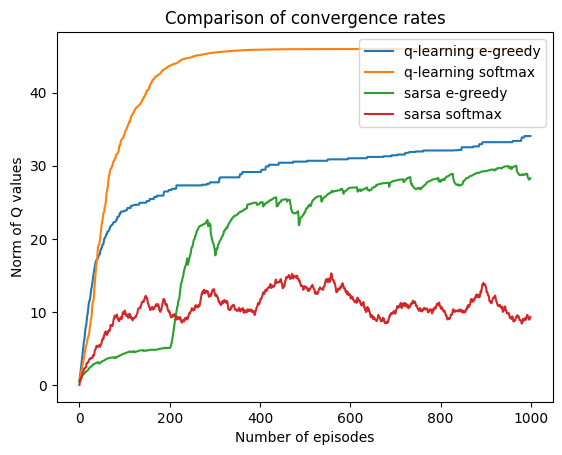

<Figure size 640x480 with 0 Axes>

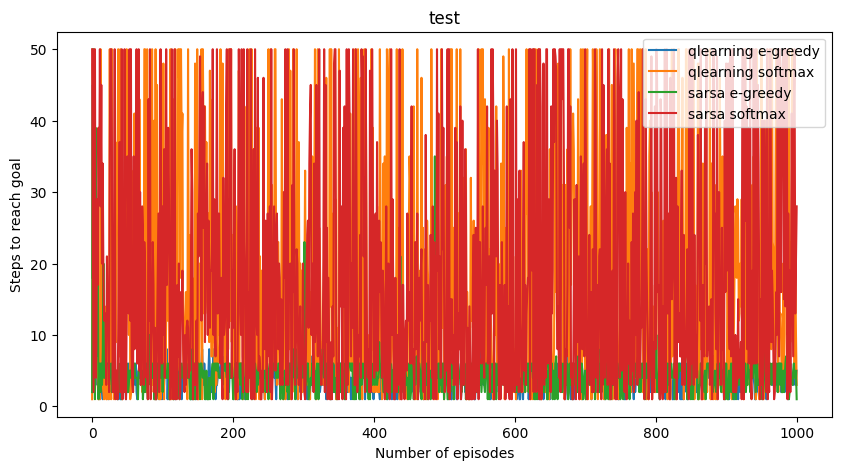

In [21]:
# example
plot_ql_sarsa(
    env, epsilon=0.02, beta=6, nb_episodes=1000, timeout=100, alpha=0.5, render=False
)

### Effect of hyper-parameters

The other two hyper-parameters of **q-learning** and **sarsa** are $\alpha$,
and $\gamma$. By varying the values of these hyper-parameters and watching the
learning process and behavior of the agent, explain their impact on the
algorithm. Using additional plotting functions is also welcome.

A good idea to visualize the effect of two parameters is to generate a heat map
by letting both parameters take values in a well-chosen interval

### 超参数的影响

**q-learning** 和 **sarsa** 的另外两个超参数是 $\alpha$（学习率）和 $\gamma$（折扣因子）。通过调整这些超参数的值并观察学习过程和智能体的行为，解释它们对算法的影响。使用额外的绘图函数来辅助分析也是欢迎的。

一个很好的方法来可视化两个参数的影响是生成热图，让两个参数在一个合理的区间内取值。

alpha = 0.2, epsilon = 0.02


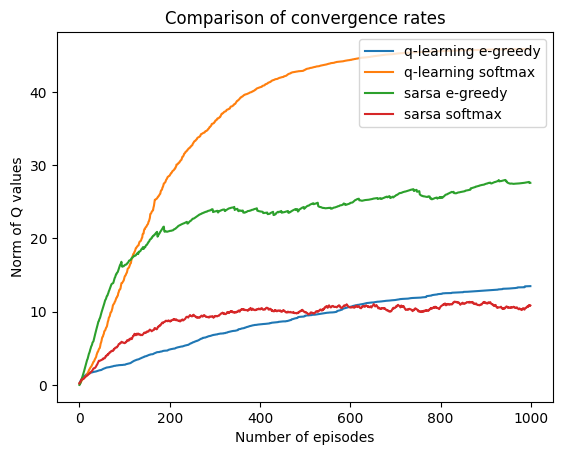

<Figure size 640x480 with 0 Axes>

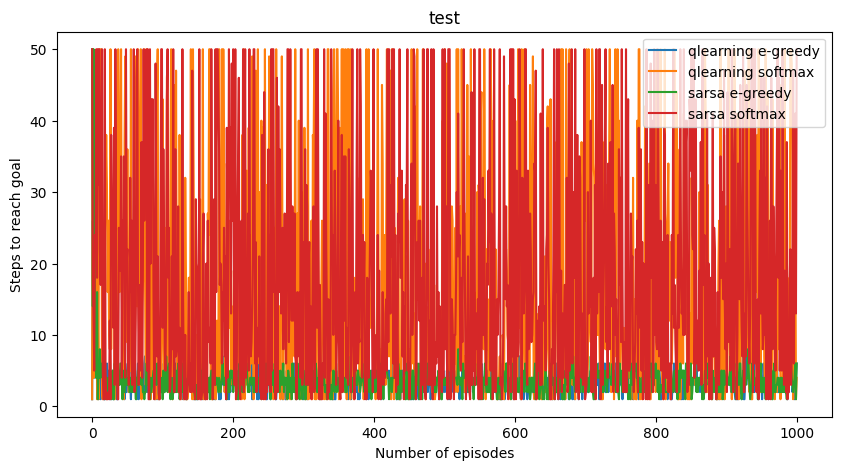

alpha = 0.2, epsilon = 0.2


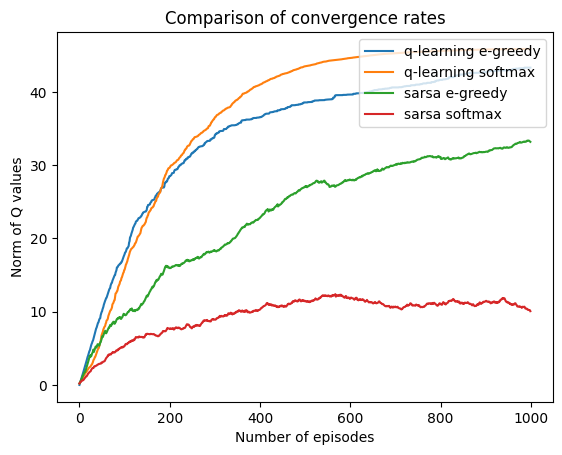

<Figure size 640x480 with 0 Axes>

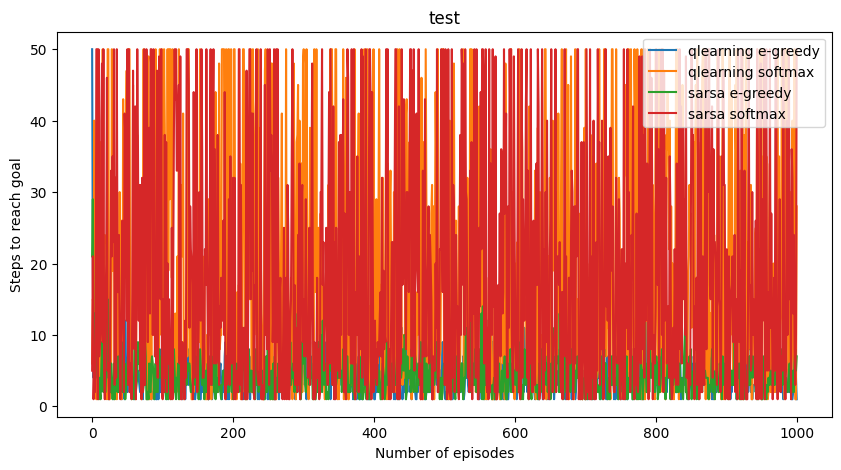

alpha = 0.2, epsilon = 0.5


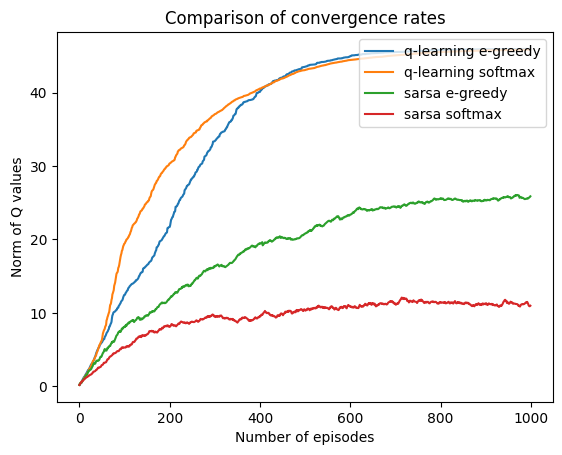

<Figure size 640x480 with 0 Axes>

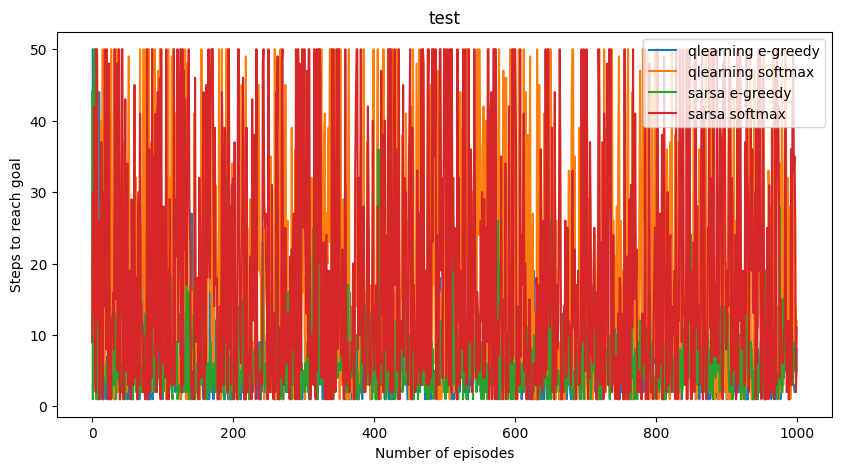

alpha = 0.5, epsilon = 0.02


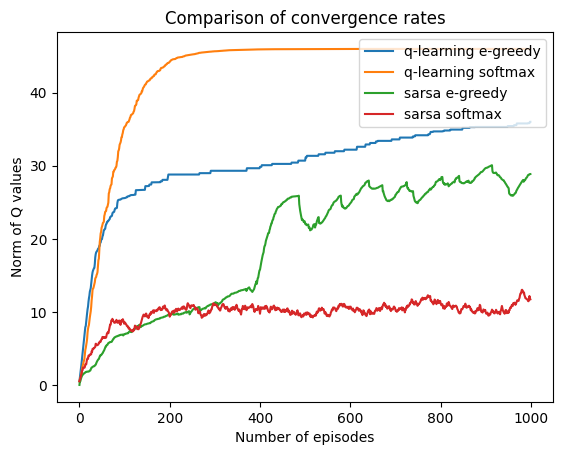

<Figure size 640x480 with 0 Axes>

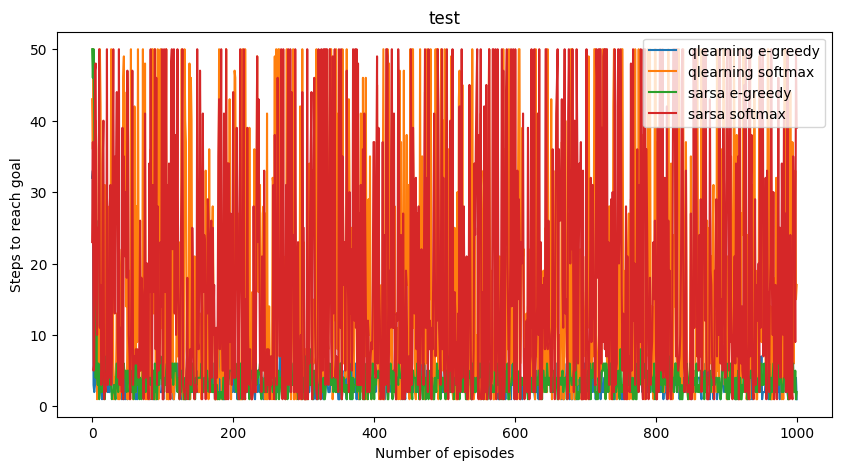

alpha = 0.5, epsilon = 0.2


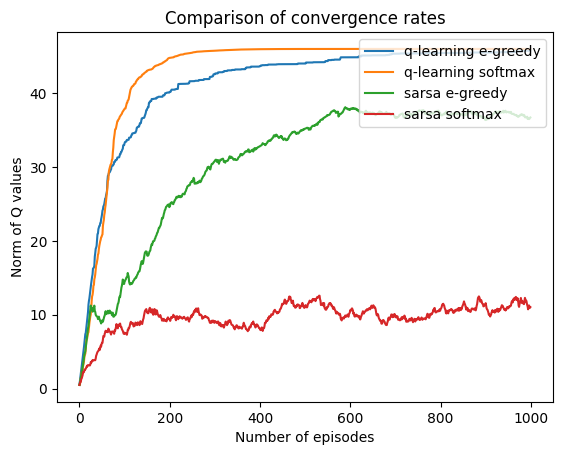

<Figure size 640x480 with 0 Axes>

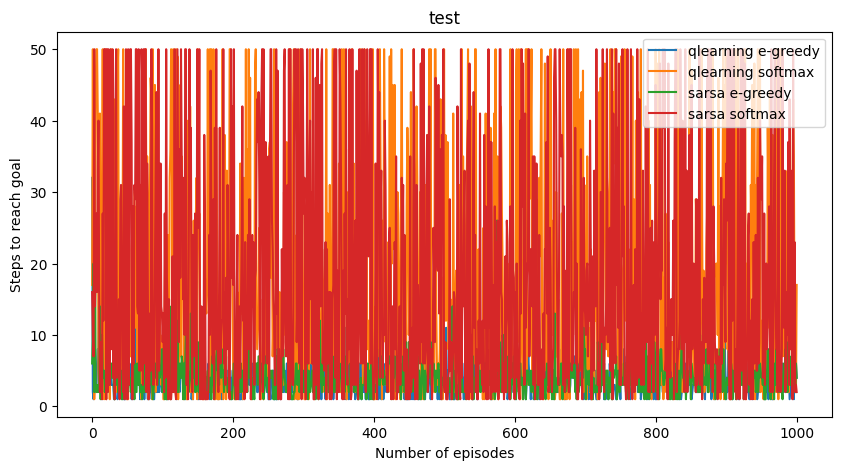

alpha = 0.5, epsilon = 0.5


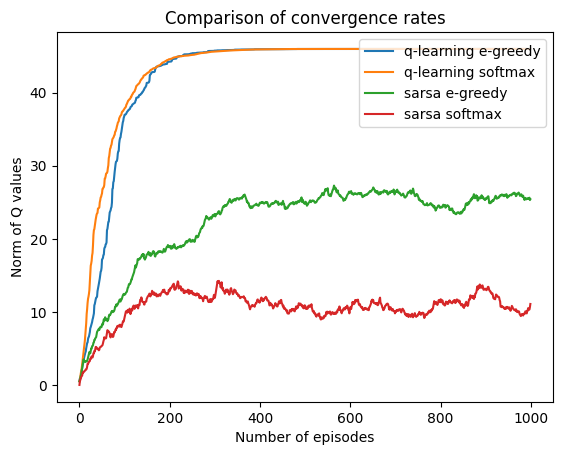

<Figure size 640x480 with 0 Axes>

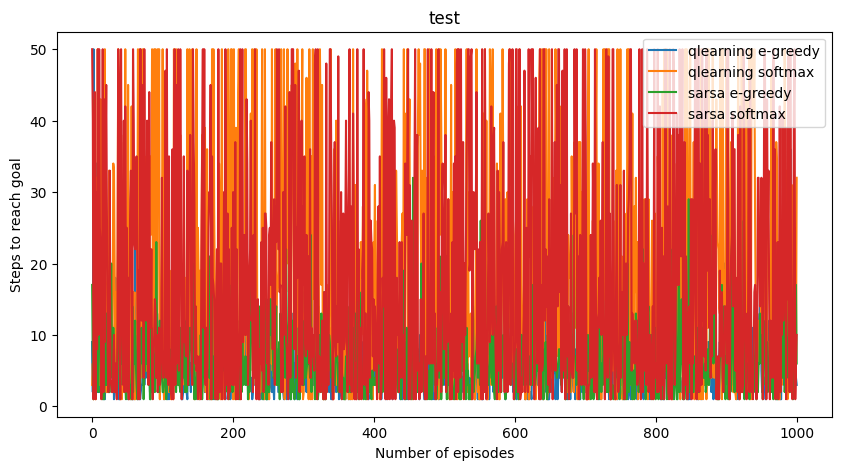

alpha = 0.7, epsilon = 0.02


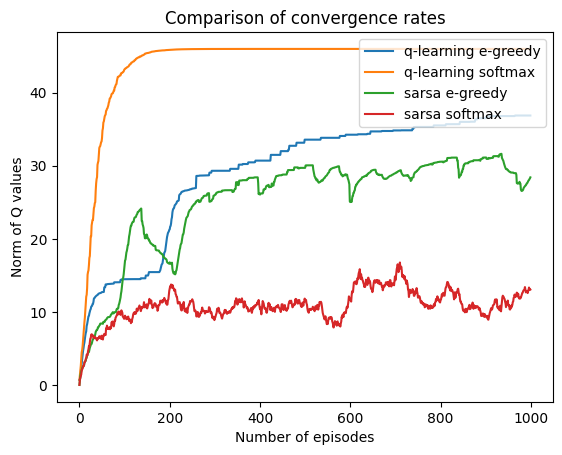

<Figure size 640x480 with 0 Axes>

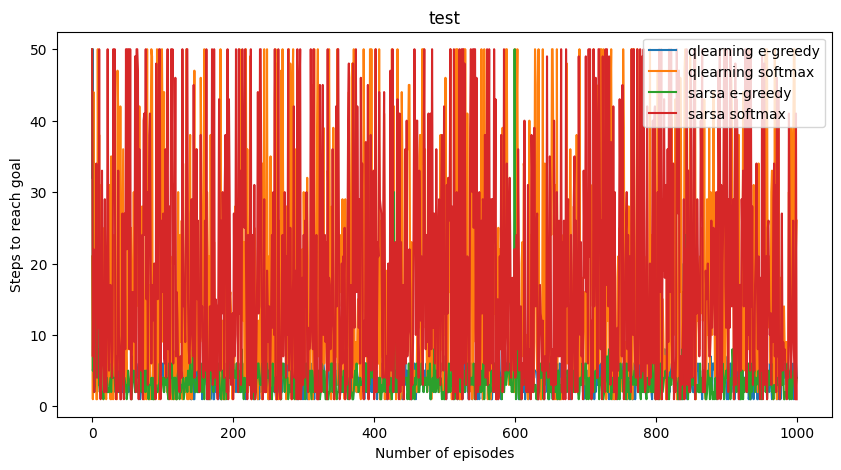

alpha = 0.7, epsilon = 0.2


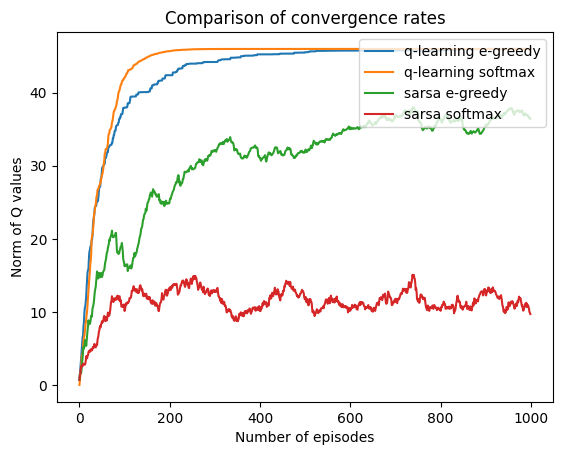

<Figure size 640x480 with 0 Axes>

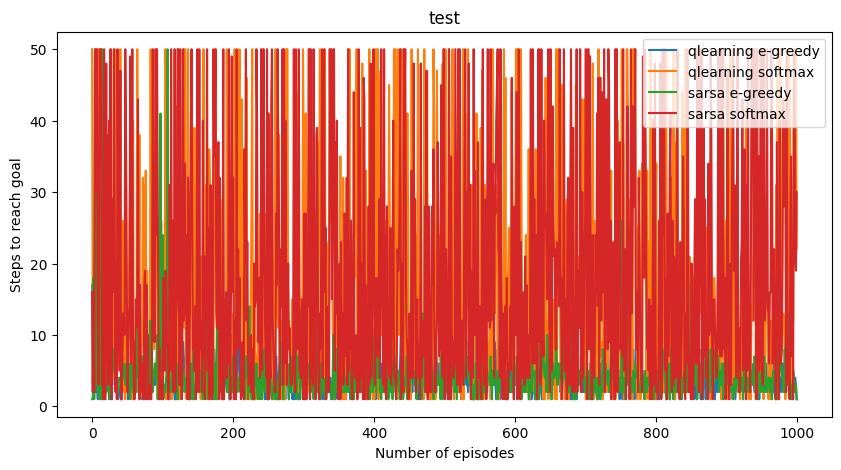

alpha = 0.7, epsilon = 0.5


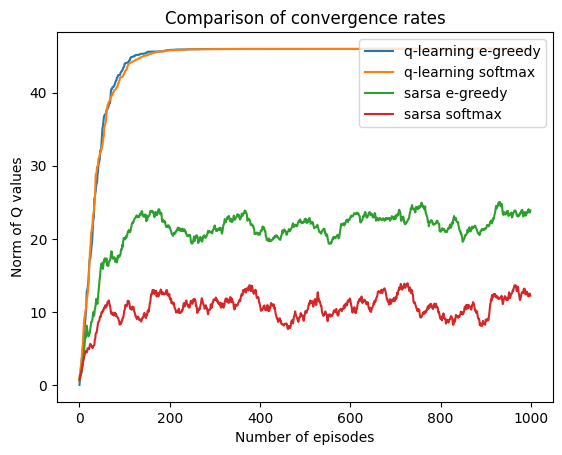

<Figure size 640x480 with 0 Axes>

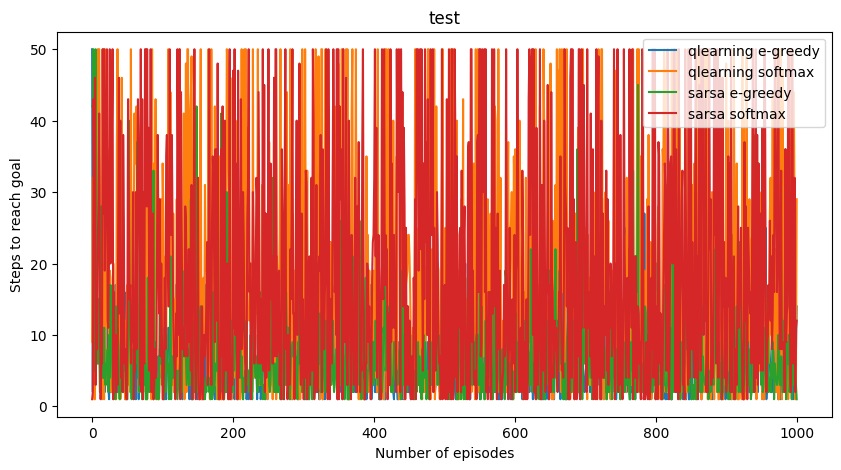

In [22]:
# To be completed...
alpha_list = [0.2, 0.5, 0.7]
epsilon_list = [0.02, 0.2, 0.5]

for alp in alpha_list:
    for eps in epsilon_list:
        print(f"alpha = {alp}, epsilon = {eps}")
        plot_ql_sarsa(
            env, epsilon=eps, beta=6, nb_episodes=1000, timeout=100, alpha=alp, render=False
        )

# Put your visualization code here
# assert False, 'Not implemented yet'
